In [ ]:
!pip install featurewiz

In [144]:
## import packages
%matplotlib inline

from __future__ import print_function
from __future__ import division

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from warnings import filterwarnings
filterwarnings('ignore')

## import utility functions
from utils import feature_engineer

In [169]:
## load the training data
train_features = pd.read_csv('Data/RawData/dengue_features_train.csv')
train_labels = pd.read_csv('Data/RawData/dengue_labels_train.csv')
## merge features and labels
training_data = train_features.merge(train_labels, on=['city','year','weekofyear']).sort_values('week_start_date')

In [170]:
## Some features should be generated
training_data['month'] = pd.to_datetime(training_data['week_start_date']).dt.month

# Combined data for two locations
# training_data_sj = feature_engineer.create_weekly_features(training_data[training_data['city'] == 'sj'])
# training_data_iq = feature_engineer.create_weekly_features(training_data[training_data['city'] == 'iq'])
# training_data = pd.concat([training_data_sj, training_data_iq], ignore_index=True)

In [171]:
## Seperate training and validation data for San Juan
sj_train_features, sj_validation_features, sj_train_labels, sj_validation_labels = train_test_split(training_data[training_data['city']=='sj'].drop(columns='total_cases'),
                                                                                                   training_data[training_data['city']=='sj']['total_cases'],
                                                                                                   train_size=0.9,
                                                                                                   shuffle=False)

## Separate training and validation data for Iquitos
iq_train_features, iq_validation_features, iq_train_labels, iq_validation_labels = train_test_split(training_data[training_data['city']=='iq'].drop(columns='total_cases'),
                                                                                                   training_data[training_data['city']=='iq']['total_cases'],
                                                                                                   train_size=0.9,
                                                                                                   shuffle=False)

In [172]:
## combine sj and iq
train_features = pd.concat([sj_train_features, iq_train_features])
validation_features = pd.concat([sj_validation_features, iq_validation_features])

## log transformation for target values
train_labels = np.log1p(pd.concat([sj_train_labels, iq_train_labels]))
validation_labels = np.log1p(pd.concat([sj_validation_labels, iq_validation_labels]))

In [158]:
## skewed features
right_skew_col = ['precipitation_amt_mm', 'reanalysis_precip_amt_kg_per_m2', 'reanalysis_sat_precip_amt_mm', 'station_precip_mm']
left_skew_col = ['reanalysis_dew_point_temp_k', 'reanalysis_min_air_temp_k', 'reanalysis_relative_humidity_percent', 'station_min_temp_c']

#### **Feature Removal:**
Considering the size of dataset, we will focus on tree-based algorithms, which means we do not need to care too much about highly correlated features (LightGBM and XGBoost always take a subset of features randomly). We can still remove some extremely highly-correlated features.

- Based on the description of features, reanalysis_avg_temp_k and reanalysis_air_temp_k are literally similar and indeed they are highly correlated. I decided to remove reanalysis_avg_temp_k.
- reanalysis_sat_precip_amt_mm is almost the same as precipitation_amt_mm so we just remove reanalysis_sat_precip_amt_mm.
- For ndvi-related features, we can drop ndvi_ne, which has around 13% missing values.

#### **Feature Generation:**
- We can extract month as a new feature and it turns out every model treats it as an important feature.
- Feature crossing based on knowledge, for instance, common sense tells us that mosquito prefers hot and wet weather, therefore we can use the product of temperature and humanity index.
- We can take the rolling mean of some features to reveal more information around a time period. For instance, we can take the rolling mean of two-week precipitation.

#### **Feature Transformation:**
- We can encode city column.
- Skewed features need transformation.

#### **Also...**
- There are also many packages to do feature selection, such as sklearn and featurewiz. I attached some codes for featurewiz but not using it as the main methods because the explaination of features are less clear than hand-made features. Although these new features might be useful, there are some black-box inside. Anther reason is that featurewiz can add much more new features which is not good for such a small-size dataset.
- We can also create mnay time-related features for the climate features by using tsfresh, due to the time limit, I will put this as the next step for future engineer

#### Individual Model

Text(0.5, 1.0, 'Variable Correlations')

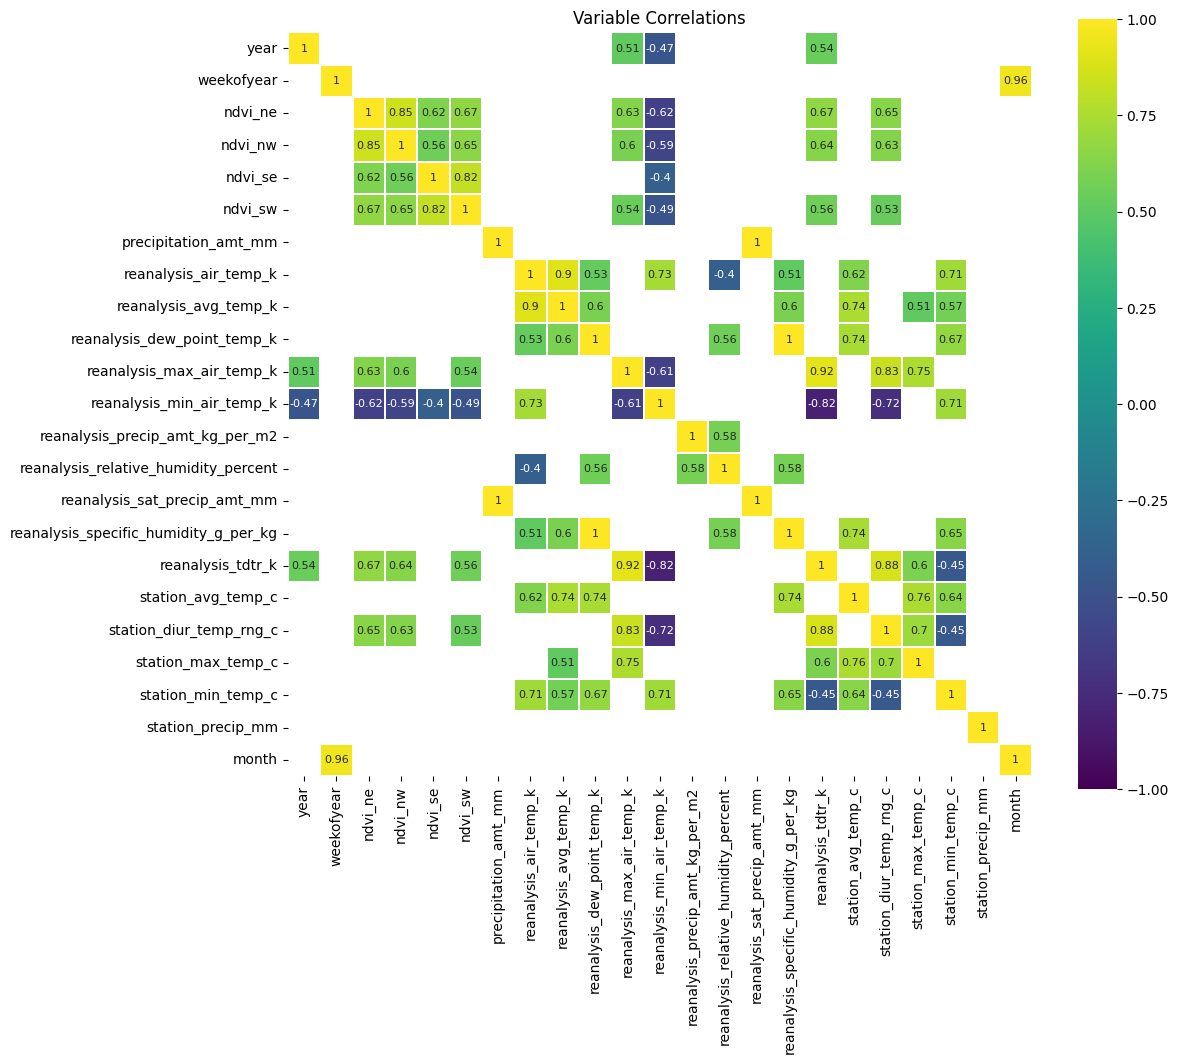

In [ ]:
## correlation between features
corr = train_features.corr()
plt.figure(figsize=(12, 10))

sns.heatmap(corr[(corr >= 0.5) | (corr <= -0.4)],
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True)
plt.title('Variable Correlations')

In [173]:
### run the pipeline of feature engineer and selection
import importlib
importlib.reload(feature_engineer)

train_features = feature_engineer.feature_engineer_pipeline(train_features, right_skew_col=right_skew_col, left_skew_col=left_skew_col)
validation_features = feature_engineer.feature_engineer_pipeline(validation_features, right_skew_col=right_skew_col, left_skew_col=left_skew_col)

In [ ]:
### store outputs
train_features.to_csv("Data/ProcessedData/train_features.csv", index=False)
train_labels.to_csv("Data/ProcessedData/train_labels.csv", index=False)
validation_features.to_csv("Data/ProcessedData/validation_features.csv", index=False)
validation_labels.to_csv("Data/ProcessedData/validation_labels.csv", index=False)

#### Two Models by location

In [ ]:
## run the pipeline of feature engineer and selection
sj_train_features = feature_engineer.feature_engineer_pipeline(sj_train_features)
sj_validation_features = feature_engineer.feature_engineer_pipeline(sj_validation_features)
iq_train_features = feature_engineer.feature_engineer_pipeline(iq_train_features)
iq_validation_features = feature_engineer.feature_engineer_pipeline(iq_validation_features)

In [ ]:
## store outputs
sj_train_features.to_csv("Data/ProcessedData/sj_train_features.csv", index=False)
sj_train_labels.to_csv("Data/ProcessedData/sj_train_labels.csv", index=False)
sj_validation_features.to_csv("Data/ProcessedData/sj_validation_features.csv", index=False)
sj_validation_labels.to_csv("Data/ProcessedData/sj_validation_labels.csv", index=False)

iq_train_features.to_csv("Data/ProcessedData/iq_train_features.csv", index=False)
iq_train_labels.to_csv("Data/ProcessedData/iq_train_labels.csv", index=False)
iq_validation_features.to_csv("Data/ProcessedData/iq_validation_features.csv", index=False)
iq_validation_labels.to_csv("Data/ProcessedData/iq_validation_labels.csv", index=False)

#### Featurewiz

Imported 0.3.2 version. Select nrows to a small number when running on huge datasets.
output = featurewiz(dataname, target, corr_limit=0.90, verbose=2, sep=',', 
		header=0, test_data='',feature_engg='', category_encoders='',
		dask_xgboost_flag=False, nrows=None, skip_sulov=False, skip_xgboost=False)
Create new features via 'feature_engg' flag : ['interactions','groupby','target']

############################################################################################
############       F A S T   F E A T U R E  E N G G    A N D    S E L E C T I O N ! ########
# Be judicious with featurewiz. Don't use it to create too many un-interpretable features! #
############################################################################################
featurewiz has selected 0.7 as the correlation limit. Change this limit to fit your needs...
Skipping category encoding since no category encoders specified in input...
#### Single_Label Regression problem ####
    Loaded train data. Shape = 

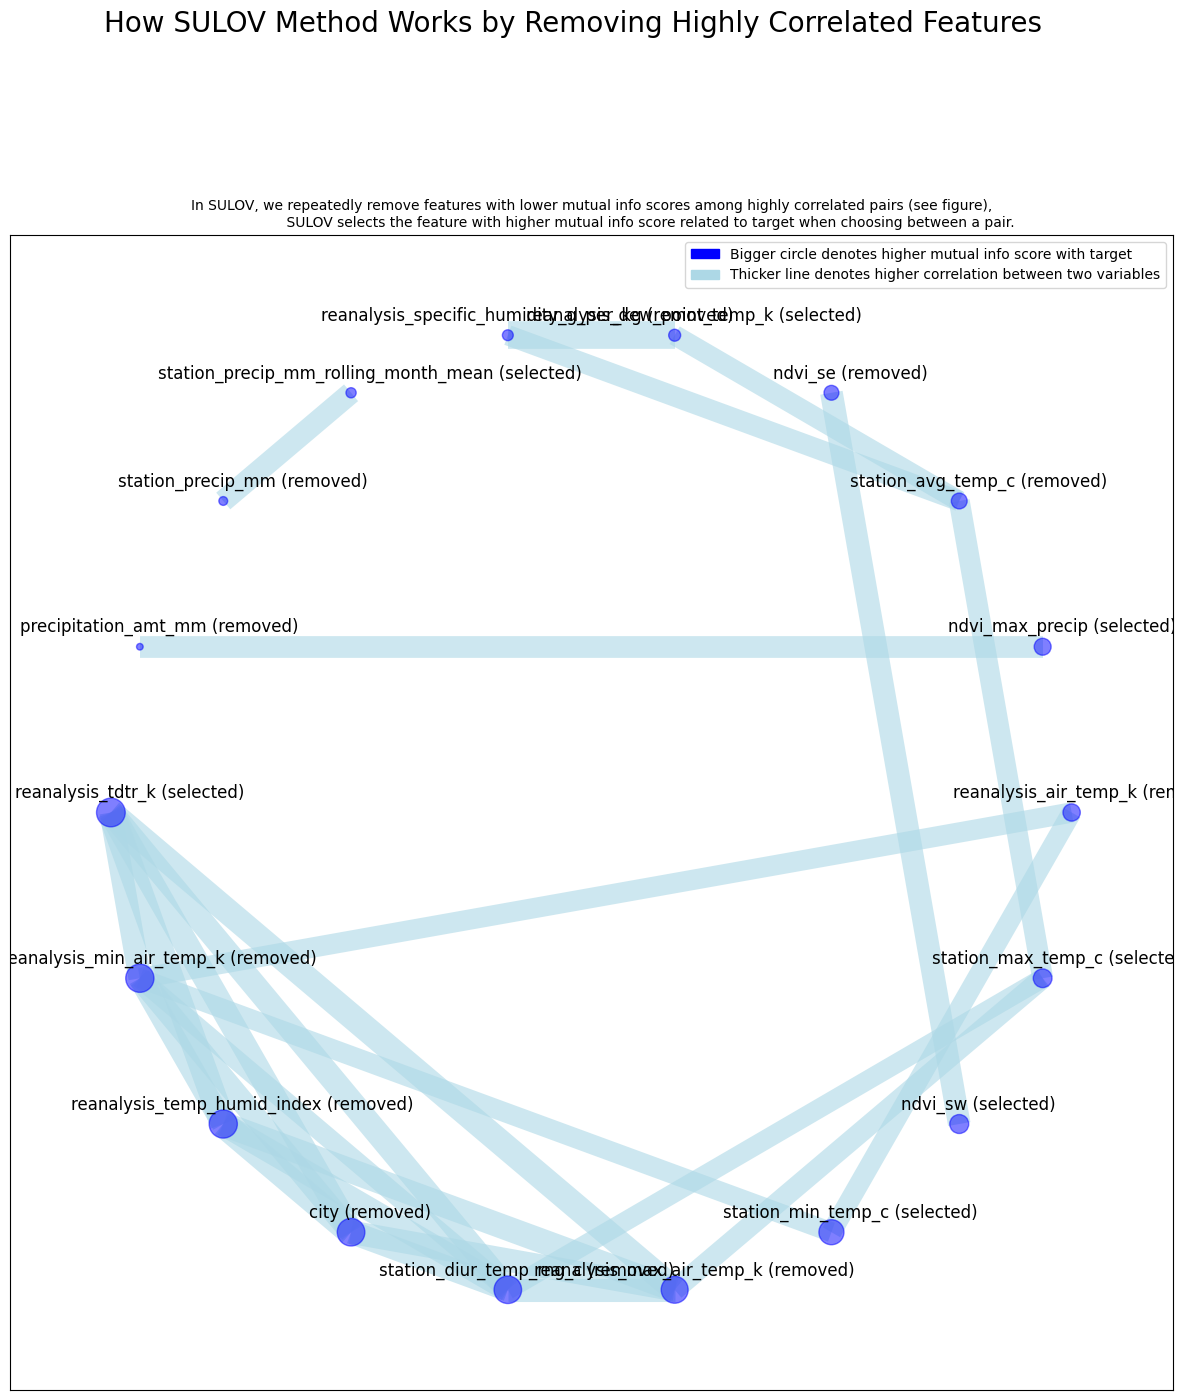

Time taken for SULOV method = 2 seconds
    Adding 0 categorical variables to reduced numeric variables  of 12
Final list of selected 12 vars after SULOV = ['ndvi_nw', 'reanalysis_precip_amt_kg_per_m2', 'reanalysis_relative_humidity_percent', 'month', 'station_precip_mm_diff', 'reanalysis_tdtr_k', 'station_min_temp_c', 'ndvi_sw', 'station_max_temp_c', 'ndvi_max_precip', 'reanalysis_dew_point_temp_k', 'station_precip_mm_rolling_month_mean']
Converting all features to numeric before sending to XGBoost...
#######################################################################################
#####    R E C U R S I V E   X G B O O S T : F E A T U R E   S E L E C T I O N  #######
#######################################################################################
    using regular XGBoost
Since ['groupby', 'target'] category encoding is done, dropping original categorical vars from predictors...
    Taking top 5 features per iteration...
    XGBoost version using 2.0.1 as tree method: gp

In [176]:
from featurewiz import featurewiz

train = pd.concat([train_features, train_labels], axis=1)
validation = pd.concat([validation_features, validation_labels], axis=1)

dft = featurewiz(train,
                 'total_cases',
                 corr_limit = 0.70,
                 verbose = 1,
                 test_data = validation,
                 feature_engg = ["groupby",
                                #  'interactions',
                                 'target'],
                 category_encoders=''
                     )

In [ ]:
train_data, validation_data = dft

In [ ]:
# from xgboost import XGBRegressor, plot_importance
# from sklearn.metrics import mean_absolute_error

# ## XGBoost
# xgb = XGBRegressor()
# xgb.fit(train_data.drop(columns='total_cases'), train_data['total_cases'], eval_metric = mean_absolute_error)
# Y_pred = xgb.predict(validation_data)

# mean_absolute_error(validation_labels, Y_pred)